In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, UnivariateSpline
from __future__ import division

# Problem 1

In [91]:
t_decay = 2.6234 * 365.241 * 24 * 60 * 60
t_bio = 138 * 24 * 60 * 60
t_effective = t_decay * t_bio / (t_decay + t_bio) * 24 * 60 * 60
lambda_p = np.log(2) / t_decay
lambda_b = np.log(2) / t_bio
t_effective # seconds

900474488372.5688

Energy information obtained from [Lund/LBNL Cinderella site](http://nucleardata.nuclear.lu.se/toi/nuclide.asp?iZA=610147)

In [92]:
E = 224.1 * 1000. * 1.6e-19 # keV to J
w = 1.

In [93]:
25. * (lambda_b + lambda_p) / E * .011

510080.41059187689

In [94]:
25. * (lambda_b + lambda_p) / E

46370946.417443357

# Problem 2

Cross sections downloaded from the [BNL Sigma web page](http://www.nndc.bnl.gov/sigma/index.jsp?as=59&lib=endfb7.1&nsub=10)

In [95]:
cross_section = pd.read_csv('cobalt-60-n-gamma.txt')

In [96]:
sigma_interp = interp1d(cross_section['27-Co-59(n'], cross_section[u'&gamma;) ENDF/B-VII.1'])
sigma_interp(0.0253)

array(37.2756)

The absorption cross section for Co-60 is assumed to be negligible.

In [97]:
N_0_59 = 1e-6 * 6.022e23 / 60.
N_0_59

1.0036666666666666e+16

In [98]:
def N_59(t):
    flux = 1e15
    cross_section = sigma_interp(0.0253) * 1e-24 # convert barns to cm^2
    return N_0_59 * np.exp(-flux * cross_section * t)

In [99]:
def N_60(t):
    flux = 1e15
    cross_section = sigma_interp(0.0253) * 1e-24 # convert barns to cm^2
    
    decay_const = np.log(2.) / (5.2713 * 365.241 * 24. * 60. * 60.)
    
    numerator = flux * cross_section * N_59(t)
    denominator = decay_const - flux * cross_section
    
    time_factor = np.exp(-flux * cross_section * t) - np.exp(-decay_const * t)
    
    return numerator * time_factor / denominator

In [100]:
def activity(t):
    decay_const = np.log(2.) / (5.2713 * 365.241 * 24. * 60. * 60.)
    
    return decay_const * N_60(t)

In [101]:
activity(24 * 24 * 60 * 60)

2866880.7768756356

The activity is 2.87 * 10^6 Bq

In [102]:
N_0_59 - N_59(24 * 24 * 60 * 60)

746556887576438.0

7.47 * 10^14 atoms of Co-59 have been removed in that time

# Problem 3

In [103]:
E = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 15., 20., 25.]
kerma_per_fluence = [1.36e-11, 1.23e-10, 1.21e-9, 1.30e-8, 7.23e-8, 2.71e-7, 3.32e-7, 3.91e-7, 4.49e-7, 4.92e-7, 5.06e-7, 5.38e-7, 5.52e-7, 5.75e-7, 6.11e-7, 7.05e-7, 7.55e-7, 7.48e-7]
interp = interp1d(E, kerma_per_fluence)
# interp = UnivariateSpline(E, kerma_per_fluence, k=5)

In [104]:
phi = 1 / interp(14.1)

In [105]:
phi

1453319.3814672711

# Problem 4 #

In [106]:
data = pd.DataFrame(
    {
        "Depth": [0.01, 0.05, 0.1, 0.2],
    }
)

In [107]:
def dose(depth):
    # Neglecting buildup factor (ignoring scatter)
    # Assuming, based on appendix 11, that d_m = 0.5cm = 0.005m
    mu = 6.5 # inverse meters
    F = 0.8 # meters
    D_max = 100 # rad
    d_m = 0.005 # meters
    
    ret = D_max * ((F + d_m) / (F + depth))**2 * np.exp(-mu * (depth - d_m))
    
    return ret

In [108]:
data["Calculated"] = dose(depth)

In [109]:
data["Measured"] = [98.2, 78.5, 55.6, 27.2]

In [110]:
data["BF"] = data["Measured"] / data["Calculated"]

In [111]:
data["BS Dose Contribution"] = data["Measured"] - data["Calculated"]

In [141]:
data

,Depth,Calculated,Measured,BF,BS Dose Contribution
0,0.01,95.610844,98.2,1.027080,2.589156
1,0.05,66.945713,78.5,1.172592,11.554287
2,0.10,43.144943,55.6,1.288679,12.455057
3,0.20,18.244145,27.2,1.490889,8.955855


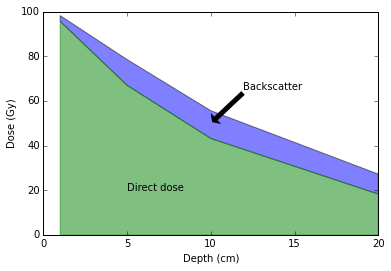

In [139]:
plt.fill_between(data["Depth"]*100, data["Calculated"], data["Measured"], alpha=0.5)
plt.fill_between(data["Depth"]*100, 0, data["Calculated"], color="green", alpha=0.5)
plt.text(0.05*100, 20, "Direct dose")
plt.annotate("Backscatter", xy=(0.1*100, 50), xytext=(0.12*100, 65), arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylabel("Dose (Gy)")
plt.xlabel("Depth (cm)")
plt.legend(loc="upper right")
plt.savefig('images/problem4.png')
plt.show()